<a href="https://colab.research.google.com/github/mdld/flux/blob/main/Copy_of_STUDY02_TS_CLASSIFY_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

updated 28 oct

# Set Up

In [13]:
# all the constants to tune the model etc. live here
BATCH_SIZE=32
CLASSES=6
LAYER_COUNT=5
HISTORY_SIZE=32 # I made this a power of 2 for the dilated convolutions to fit nicely

In [14]:
from tensorflow import keras



In [15]:
import os
try:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/.shortcut-targets-by-id/1Ceqqrb_wsA6SDV82I0HBzLQ17ezMt9v2/MariePHD
except ImportError:
  print("Can't import colab drive, hopefully this means you're running locally")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1Ceqqrb_wsA6SDV82I0HBzLQ17ezMt9v2/MariePHD


In [16]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Normalise Function


In [17]:
def normalize(dataset):
    firstrow = dataset.iloc[0]
    print("firstrow:")
    print(firstrow)
    dataNorm=(dataset-firstrow)           
    dataNorm["Label"]=dataset["Label"]
    return dataNorm

# Read Sensor Data

In [18]:
## Iterate through the Participant Sensor Datafiles, reading them into Pandas dataframes named file0 to file5

header_list = ["A0L", "A0V", "A1L", "A1V", "A2L", "A2V", "A3L", "A3V", "A4L", "A4V", "A5L", "A5V", "A6L", "A6V"]

alldata = None
i = -1
file_list = ["STUDY02/Participant1/Data_230_56.csv",    #file0 surprise
             "STUDY02/Participant1/Data_230_57.csv",    #file1 sadness
             "STUDY02/Participant1/Data_230_58.csv",    #file2 joy
             "STUDY02/Participant1/Data_230_59.csv",    #file3 fear
             "STUDY02/Participant1/Data_230_60.csv",    #file4 anger
             "STUDY02/Participant1/Data_230_61.csv"]    #file5 disgust

for f in file_list:
  i = i + 1
  #print('file'+str(i))         
  file_name = 'file'+str(i) 
  
  file = pd.read_csv(f,sep=",",names=header_list,skiprows=3)                                # study02 code
  #file = file.drop(["A0L","A0V","A1L","A2L","A3L","A4L","A5L","A6L"], axis=1, inplace=True) # study02 code - drop label columns

  file = file.drop(["A0L","A0V","A1L","A2L","A3L","A4L","A5L","A6L"], axis=1)               # study02 code - drop label columns

  #print(f), print(file_name),print(file.head())

  #file['Label'] = i
  file.insert(0,'Label',i)  # add label column with file number label (represents emotion class)


  print(file.tail(1))

  file = file.iloc[:-1 , :]

  file = normalize(file)  # use JM's normalize function (above)

  alldata = pd.concat([alldata, file], axis=0)  # combine all 6 datasets into one

  

  # convert to numpy array (all data, all 6 classes)
  alldata_np = alldata.to_numpy()
  x_data = alldata_np[:,1:]
  y_data = alldata_np[:,0]

print(alldata.head())
print(alldata.tail())



     Label  A1V  A2V  A3V  A4V  A5V  A6V
NaN      0  145  142  157  151  151  153
firstrow:
Label      0
A1V      162
A2V      159
A3V      173
A4V      167
A5V      162
A6V      171
Name: nan, dtype: int64
     Label  A1V  A2V  A3V  A4V  A5V  A6V
NaN      1  137  134  NaN  NaN  NaN  NaN
firstrow:
Label      1.0
A1V      138.0
A2V      136.0
A3V      148.0
A4V      143.0
A5V      147.0
A6V      148.0
Name: nan, dtype: float64
     Label  A1V  A2V  A3V  A4V  A5V  A6V
NaN      2  NaN  NaN  NaN  NaN  NaN  NaN
firstrow:
Label      2.0
A1V      139.0
A2V      138.0
A3V      151.0
A4V      143.0
A5V      141.0
A6V      149.0
Name: nan, dtype: float64
     Label  A1V  A2V  A3V  A4V  A5V  A6V
NaN      3  125  125  142  133  126  144
firstrow:
Label      3
A1V      133
A2V      128
A3V      144
A4V      135
A5V      133
A6V      140
Name: nan, dtype: int64
     Label  A1V  A2V  A3V  A4V  A5V  A6V
NaN      4  129  126  141  131  128  NaN
firstrow:
Label      4.0
A1V      125.0
A2V      123.0
A3V

In [19]:
alldata.describe()

,Label,A1V,A2V,A3V,A4V,A5V,A6V
count,7258.000000,7258.000000,7258.000000,7258.000000,7258.000000,7258.000000,7258.000000
mean,2.228024,-1.962800,-1.045329,-0.855332,-0.065583,-1.021218,-0.637779
std,1.762204,6.440707,6.019720,6.507647,6.306432,7.987974,6.554199
min,0.000000,-19.000000,-18.000000,-19.000000,-19.000000,-19.000000,-20.000000
25%,1.000000,-5.000000,-4.000000,-4.000000,-3.000000,-6.000000,-4.000000
50%,2.000000,-1.000000,0.000000,0.000000,0.000000,-2.000000,1.000000
75%,4.000000,2.000000,2.000000,3.000000,4.000000,3.000000,4.000000
max,5.000000,17.000000,18.000000,22.000000,18.000000,81.000000,17.000000


# Prepare data using Joe's generator code

In [20]:
from kerasgenerators import *

In [21]:
print("ORIG:",x_data.shape,y_data.shape)

ORIG: (7258, 6) (7258,)


In [22]:
in_dataset=LabelledHistoryGenerator(source_x=x_data,label_y=y_data,batch_size=BATCH_SIZE,history_x=HISTORY_SIZE,history_y=1)

in_dataset=ShuffledGenerator(in_dataset,seed=3)

train_dataset=TestSplitGenerator(in_dataset,split=0.5,is_test=False)
non_training_dataset=TestSplitGenerator(in_dataset,split=0.5,is_test=True)

validate_dataset=TestSplitGenerator(non_training_dataset,split=0.5,is_test=False)
test_dataset=TestSplitGenerator(non_training_dataset,split=0.5,is_test=True)


# Keras

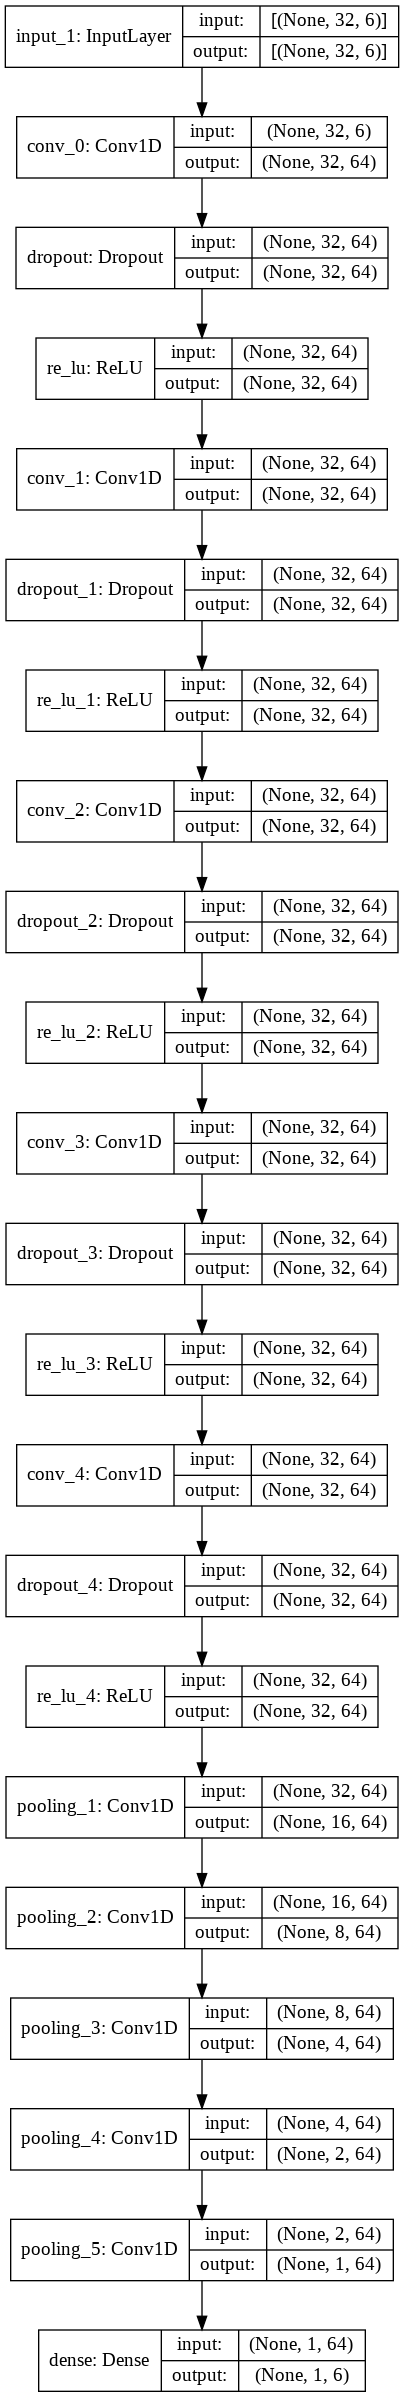

In [23]:

num_classes = CLASSES

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    this_layer=input_layer
    for c in range(LAYER_COUNT):
      this_layer = keras.layers.Conv1D(filters=64, kernel_size=2,dilation_rate=2**c, padding="same",name="conv_%d"%c)(this_layer)
#      this_layer = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(this_layer)
      this_layer=keras.layers.Dropout(0.2)(this_layer)
      this_layer = keras.layers.ReLU()(this_layer)

    # rather than average pooling, this uses a stack of width 2 convolutions which do 
    # some kind of pooling operation but which is no longer fixed
    count=0
    while this_layer.shape[-2]>1:
      count+=1
      this_layer=keras.layers.Conv1D(filters=64,kernel_size=2,strides=2,padding="valid",name="pooling_%d"%count)(this_layer)

#    this_layer = keras.layers.GlobalAveragePooling1D()(this_layer)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(this_layer)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


#model = make_model(input_shape=x_train.shape[1:])
model = make_model(train_dataset[0][0].shape[1:])
keras.utils.plot_model(model, show_shapes=True)


In [24]:
train_dataset[0][0].shape[1:]

(32, 6)

In [25]:
epochs = 50
#epochs = 500
 
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_sparse_categorical_accuracy"
    )
    #,
    #keras.callbacks.ReduceLROnPlateau(
    #    monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    #)
    #,
    #keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
#history = model.fit(
#    x_train,
#    y_train,
#    batch_size=batch_size,
#    epochs=epochs,
#    callbacks=callbacks,
#    validation_split=0.2,
#    verbose=1,
#)
 
 
history = model.fit(train_dataset,epochs=epochs,callbacks=callbacks,validation_data=validate_dataset)

Epoch 1/50
113/113 [==============================] - 35s 35ms/step - loss: 1.4940 - sparse_categorical_accuracy: 0.4179 - val_loss: 1.4220 - val_sparse_categorical_accuracy: 0.5469
Epoch 2/50
113/113 [==============================] - 3s 31ms/step - loss: 1.0654 - sparse_categorical_accuracy: 0.6126 - val_loss: 0.9593 - val_sparse_categorical_accuracy: 0.6685
Epoch 3/50
113/113 [==============================] - 4s 34ms/step - loss: 0.8247 - sparse_categorical_accuracy: 0.7251 - val_loss: 0.8991 - val_sparse_categorical_accuracy: 0.6970
Epoch 4/50
113/113 [==============================] - 4s 31ms/step - loss: 0.8683 - sparse_categorical_accuracy: 0.7765 - val_loss: 1.0175 - val_sparse_categorical_accuracy: 0.6004
Epoch 5/50
113/113 [==============================] - 3s 31ms/step - loss: 1.2012 - sparse_categorical_accuracy: 0.5938 - val_loss: 0.8300 - val_sparse_categorical_accuracy: 0.7472
Epoch 6/50
113/113 [==============================] - 3s 31ms/step - loss: 0.6295 - sparse_cat

In [26]:
model = keras.models.load_model("best_model.h5")
 
model.evaluate(train_dataset)
test_loss, test_acc = model.evaluate(test_dataset)
 
print("Test accuracy", test_acc)
print("Test loss", test_loss)

56/56 [==============================] - 1s 19ms/step - loss: 1.5984 - sparse_categorical_accuracy: 0.9258
Test accuracy 0.92578125
Test loss 1.5983917713165283


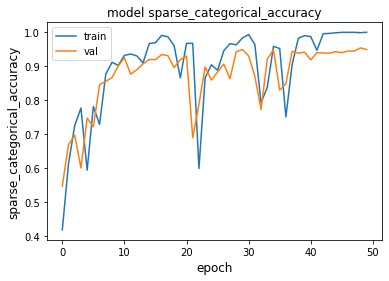

<Figure size 432x288 with 0 Axes>

In [27]:
metric = "sparse_categorical_accuracy"
 
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
#plt.close()
plt.savefig(('STUDY02/6_classes.png'))

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 6)]           0         
_________________________________________________________________
conv_0 (Conv1D)              (None, 32, 64)            832       
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 64)            0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 32, 64)            8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32, 64)            0     

In [29]:
#in_dataset.__dict__

In [30]:
#train_dataset.__dict__

In [31]:
#train_dataset[0][0].shape[1:]

In [32]:
#validate_dataset.__dict__

In [33]:
#validate_dataset[0][0].shape[1:]

In [34]:
def make_confusion_matrix(dataset,title):
  print("================")
  print(title)
  print("================")
  print("CONFUSION MATRIX")
  print("================")
  labels = np.concatenate([values[1] for values in dataset])# get all the label batches
  predictionProbabilities= model.predict(dataset) # get the predictions as a probability distribution
  
 
 
  predictions = tf.math.argmax(
    predictionProbabilities, axis=2, output_type=tf.dtypes.int64, name=None) # take argmax - predictions and labels are both now individual numbered values
 
  print(labels.shape, predictions.shape)
  matrix=tf.math.confusion_matrix(
    tf.squeeze(labels),tf.squeeze( predictions), num_classes=6
  )
  print(matrix)
  print("================")
  print("Frequencies")
  print("================")
  lab_freq=tf.reduce_sum(matrix,axis=1)
  pred_freq=tf.reduce_sum(matrix,axis=0)
  print("Labels frequencies:   ",lab_freq)
  print("Predicted frequencies:",pred_freq)
 
  print("Correct predictions:",(["%2.2f"%((matrix[c,c] / lab_freq[c]).numpy()) for c in range(6)]))

In [35]:
make_confusion_matrix(test_dataset,"TEST DATA CONFUSION MATRIX")

TEST DATA CONFUSION MATRIX
CONFUSION MATRIX
(1792, 1) (1792, 1)
tf.Tensor(
[[352   0   0  32   0   0]
 [  7 296   0   0  17   0]
 [  4   0 310   0   0  26]
 [ 10   2   0 265   0   0]
 [  0   0   0  21 265   0]
 [  0   0   2   0  12 171]], shape=(6, 6), dtype=int32)
Frequencies
Labels frequencies:    tf.Tensor([384 320 340 277 286 185], shape=(6,), dtype=int32)
Predicted frequencies: tf.Tensor([373 298 312 318 294 197], shape=(6,), dtype=int32)
Correct predictions: ['0.92', '0.93', '0.91', '0.96', '0.93', '0.92']


In [36]:
make_confusion_matrix(train_dataset,"TRAIN DATA CONFUSION MATRIX")

TRAIN DATA CONFUSION MATRIX
CONFUSION MATRIX
(3616, 1) (3616, 1)
tf.Tensor(
[[768   0   0   0   0   0]
 [  0 706   0   0   0   0]
 [  0   1 413   0   0   0]
 [  0   0   0 608   0   0]
 [  0   0   0   0 576   0]
 [  0   0   0   0   0 544]], shape=(6, 6), dtype=int32)
Frequencies
Labels frequencies:    tf.Tensor([768 706 414 608 576 544], shape=(6,), dtype=int32)
Predicted frequencies: tf.Tensor([768 707 413 608 576 544], shape=(6,), dtype=int32)
Correct predictions: ['1.00', '1.00', '1.00', '1.00', '1.00', '1.00']


In [37]:
make_confusion_matrix(validate_dataset,"VALIDATION DATA CONFUSION MATRIX")

VALIDATION DATA CONFUSION MATRIX
CONFUSION MATRIX
(1792, 1) (1792, 1)
tf.Tensor(
[[494   5   6  26   0   3]
 [ 29 257   0   4   8   0]
 [  0   0 160   0   0   0]
 [  0   2   0 350   0   0]
 [  0   0   0   0 160   0]
 [  0   0   0   0   0 288]], shape=(6, 6), dtype=int32)
Frequencies
Labels frequencies:    tf.Tensor([534 298 160 352 160 288], shape=(6,), dtype=int32)
Predicted frequencies: tf.Tensor([523 264 166 380 168 291], shape=(6,), dtype=int32)
Correct predictions: ['0.93', '0.86', '1.00', '0.99', '1.00', '1.00']


In [38]:
import csv   
import datetime
    
# headers
header = [['Run Date Time', 'Number of Classes', 'Batch Size', 'History Size','Epochs','Test Accuracy','Test Loss']]

# data rows of csv file  
rows = [[datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), CLASSES, BATCH_SIZE, HISTORY_SIZE, epochs, test_acc, test_loss ]]
    
# name of csv file  
filename = "outfile_fs_6_classes_info.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  

    # writing the header row 
    csvwriter.writerows(header)         

    # writing the data rows  
    csvwriter.writerows(rows) 